# Exploring NFL Yards-Per-Play Distributions, using R/ggplot

In this post I'd like to dive into NFL yards-per-play (ypp) outcomes, looking at ypp distributions under different conditions. I'll be using NLF 2009-2015 play-by-play data that I've downloaded using the awesome R library [nflscrapR](https://github.com/maksimhorowitz/nflscrapR)

For the R code used to query data using nflScrapR, or for an overview of the variables available with it, see **[my previous blog post link]**

## Load/Prep the Data

In [481]:
#Load libraries
library(ggplot2)
library(sqldf)
library(dplyr)
library(scales)
library(assertthat)

#Import data
pbp_data <- read.csv('/home/max/nfl_stats/data/pbp_2009_2015.csv')

#Adjust default height of ggplot charts
options(repr.plot.height = 4)

Now let's filter the data a bit to keep only the rows/columns we're interested in. Also, let's make sure we count sacks as pass attempts.

In [482]:
#filter play-by-play data to just relevant rows/columns
#keep_columns = c('PlayType', 'GameID', 'Season', 'Drive', 'qtr', 'down', 'desc', 'yrdline100', 'ydstogo', 'posteam', 'DefensiveTeam', 'Yards.Gained', 'Touchdown', 'Safety', 'Fumble', 'InterceptionThrown', 'PenaltyType', 'Penalty.Yards', 'PenalizedTeam')
pbp_data_2 = subset(pbp_data, PlayType %in% c('Pass', 'Run', 'Sack') & down %in% c(1,2,3,4))#, select=keep_columns)

#Remove original pbp_data from memory so I don't accidentally reference it
rm(pbp_data)
 
#Sacks are pass attempts
pbp_data_2$PlayType[pbp_data_2$PlayType=='Sack'] <- 'Pass' 

## High-Level Distribution of Yards-Per-Play Outcomes

On average, an NFL play nets 5.5 yards. What does the distribution of outcomes look like?

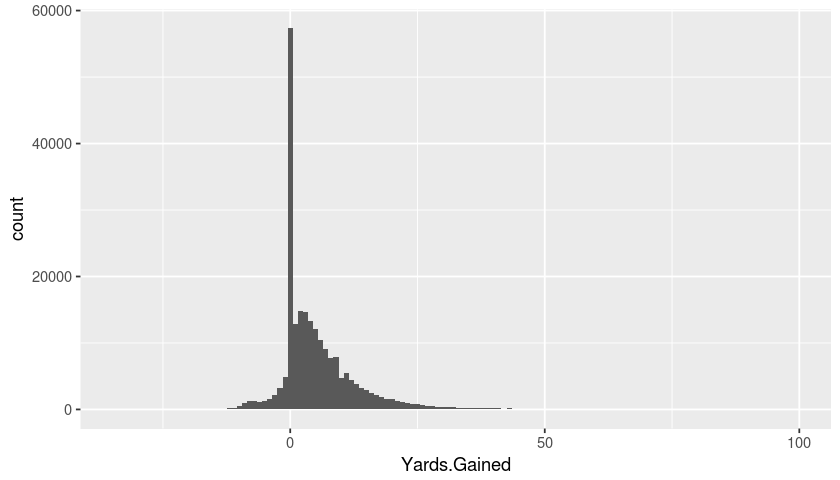

In [191]:
ggplot(pbp_data_2, aes(x=Yards.Gained)) + 
  geom_histogram(binwidth=1)

What stands out here is the huge spike at 0 Yards.Gained. This makes sense, given that about 35-40% of all pass-plays are incomplete passes and so gain zero yards.

Let's break out the yards-per-play distributions by run vs pass plays. We can do this by adding fill=PlayType below. We'll also add y=..density.. so that the y-axis is formatted proportionally. 

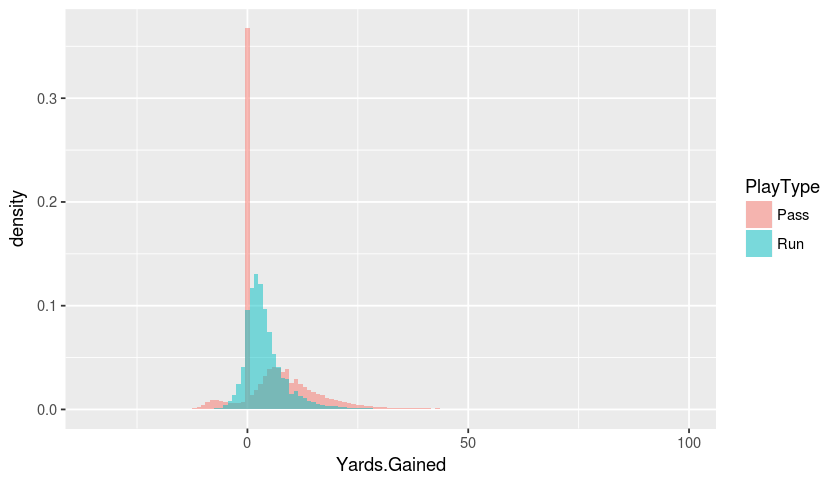

In [192]:
plot <- ggplot(pbp_data_2, aes(x=Yards.Gained, y=..density..)) + 
            geom_histogram(aes(fill=PlayType), binwidth=1, alpha=0.5, position="identity") 

plot


This to me is a really interesting plot. One things to note: the bars for each PlayType sum to 1. So the spike for Pass plays at 0 shows that about 37% of all *pass plays* net 0-yards, not that 37% of all plays are 0-yard pass plays.

## Reducing the blank space

Before we dive deeper into slicing yards-per-play distributions, we should do something about the fact that our plot above is mostly empty space. 

Cropping out the wasted horizontal space is straightforward. For the vertical space, we have a single vertical bar which we expect to extend way past all others in multiple variations of this chart. In this case, I think the best approach is to crop that as well, and leave an annotated note with how high it extends. 

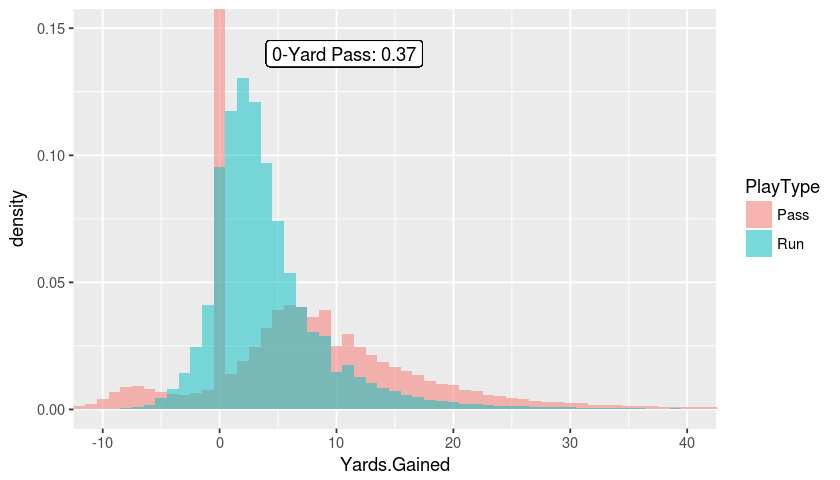

In [448]:
#Update plot with new/cropped x/y-axis ranges 
plot <- plot + coord_cartesian(ylim = c(0, .15), xlim = c(-10, 40)) 

#Get internal data underlying plot-image as dataframe, from ggbuild_data(). For use in annotation 
ggbuild_data <- as.data.frame(ggplot_build(plot)$data)

#Plot with annotation for height of truncated bar 
annotated_plot <- plot + geom_label(data=ggbuild_data, 
                                    aes(x = 4, hjust=0, y = .14, label = paste0("0-Yard Pass: ", 
                                                                       round(max(density), digits=2)))) 
annotated_plot


This plot is much clearer, and looks much more amenable to comparing multiple versions side-by-side.

There's two plotting decision embedded in the code which is worth making clear: First, the plot above "zooms in" on the range of the plot we're interested in, but keeps the bar heights as the calculated proportions based on *all* the data. ggplot did this because we used `xlim` & `ylim` inside of `coord_cartesian()`. If we had wanted the probability distribution itself to be re-calculated based on just the data within our narrowed window, we could have used `xlim` & `ylim` as ggplot options outside of `coord_cartesian()`. That would filter the data-set before calculating the densities for each Yards.Gained value. See [this Stack Overflow answer](http://stackoverflow.com/questions/3606697/how-to-set-limits-for-axes-in-ggplot2-r-plots/3606798#3606798)

Second, the .37 label/calculation is actually just taking the maximum height of any bar, which I assume will be 0-yard Pass for any slicing of this data given the prevalence of incomplete passes. But if I produce some variation of this plot where another bar goes off the screen, I'd need to 

## Using Grid Subplots to Compare Distributions Under Different Scenarios

### Getting Text Labels to Show Up Correctly in Each Subplot

Creating grids of sub-plots with ggplot is really convenient, although you have to be careful when you want ggplot to calculate summary stats for you based on the faceting variable. 

The code below shows how simple it is to break out probability distributions by categories, but also suggests to us that the max(..density..) calculation is not being grouped by the faceting variable "down". We're getting the same .37 proportion in each subplot that we know from above is the global average. For some addiitional discussion of this behavior, see these Stack Overflow threads [here]() and [here]().

tl;dr - *the labeled stats in the plot below are wrong*

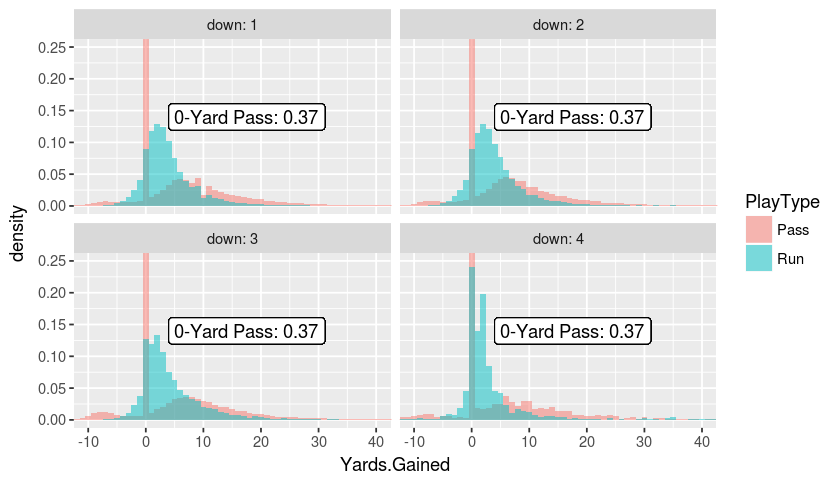

In [450]:
annotated_plot + 
    coord_cartesian(ylim=c(0,.25), xlim=c(-10, 40)) + #(extend y-axis up to .25 from .15 in last plot) 
    facet_wrap(~down, labeller = label_both)    #(create subplots for each 'down' group)

To get the labeled stats to show up correctly by facet, we can:
1. Reproduce the faceted plot, without the stat labels
2. Calculate the stat label for each subplot
3. Pass the vector of statlabels to the faceted plot to create a labeled faceted plot

In the code block below, the code comments highlight where steps 1/2/3 start.

[1] TRUE

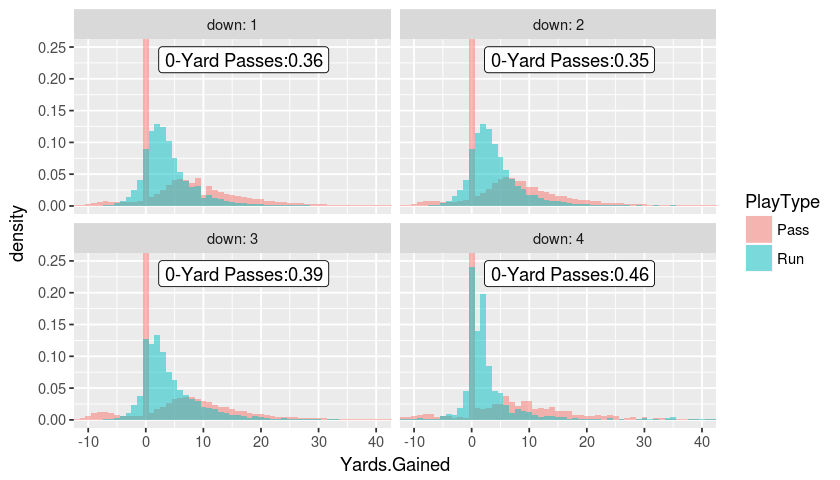

In [195]:
#1. Create Previous 'plot' Histogram, Faceted on "Down" for Subplots, without stat labels
faceted_plot <- ggplot(pbp_data_2, aes(x=Yards.Gained, y=..density..)) + 
            geom_histogram(aes(fill=PlayType), binwidth=1, alpha=0.5, position="identity") +
            coord_cartesian(ylim = c(0, .25), xlim = c(-10, 40)) +
            facet_wrap(~down, labeller = label_both)


#2. Calculate the height of the '0-yard Pass' bar for each subplot

#ggplot_build()$data has most data underlying the plot image, including densities (bar heights)
ggbuild_data <- as.data.frame(ggplot_build(faceted_plot)$data)

#ggplot_build()$layout$panel_layout maps levels of PANEL(subplot) to levels of the faceting variable 
ggbuild_panels <-ggplot_build(faceted_plot)$layout$panel_layout

#Merge two ggplot_build() datasets above so we can summarize ..density..'s by the faceting variable
ggbuild_info <- merge(ggbuild_data, ggbuild_panels[, c('PANEL', 'down')], by='PANEL', all.x = TRUE) #all.x=TRUE means left-join

#Throw error if merge somehow changed number of rows
assert_that(nrow(ggbuild_data) == nrow(ggbuild_info))

#Get Summary Stat by Panel/Down
max_bin_by_panel = sqldf("select PANEL, down, max(density) as max_density
                         from ggbuild_info
                         group by PANEL, down 
                         ")

#3. Add stat labels calculated (correctly) by down to faceted plot
labeled_faceted_plot <- faceted_plot + geom_label(data=max_bin_by_panel,
                                                 aes(x=17, y=0.23, label= paste0('0-Yard Passes:', round(max_density,2))))

labeled_faceted_plot

This is another interesting plot. A few things that stand out:
1. Negative pass plays (which we expect to be mostly sacks) appear significantly more common on 3rd downs
2. Apparently 10 Yards.Gained happens way less frequently than either 9 or 11 Yards.Gained for Pass plays on first down, which stands out from the rest of that subplot. 
3. Fourth downs have a significantly higher 0-yard pass probability and 0-yard run probability than 1st, 2nd or 3rd downs. However, while 0-yard runs on 4th down are way more common than on other downs, -1 and 1-yard runs occur with very similar frequency across all downs (about 4% and 14% of runs, respectively).

### Generalizing Our Labeled-Facet-Plot Code

I'd like to reproduce the chart above but for some different groupings as well. To make this handy, we can pull out the grouping (facet) variable and some of the plot aesthetics from the code above, so that we can easily reference the previous code for new faceting variables with just a one-line function call.

In [196]:
#Define function to create labeled/faceted plot which accepts a grouping variable and certain plotting aesthetics
plot_nfl_yards <- function(dataframe=pbp_data_2, group_by_var=down,
                           facet_cols=2, coord_xlim=c(-10, 40), coord_ylim = c(0,.25)) {
    
    #make sure "~[var]" in facet_wrap is understood by ggplot
    facet_expression <- as.formula(paste("~", group_by_var))
    
    
    #1. Create Yard.Gained Histogram, Colored by Pass/Run, Faceted on [group_by_var] for Subplots 
    faceted_plot <- ggplot(dataframe, aes(x=Yards.Gained, y=..density..)) + 
                geom_histogram(aes(fill=PlayType), binwidth=1, alpha=0.5, position="identity") +
                coord_cartesian(ylim = coord_ylim, xlim = coord_xlim) +
                facet_wrap(facet_expression, ncol=facet_cols, labeller = label_both)    
    

    #2. Calculate the height of the '0-yard Pass' bar for each subplot

    #ggplot_build()$data has most data underlying the plot image, including densities (bar heights)
    ggbuild_data <- as.data.frame(ggplot_build(faceted_plot)$data)

    #ggplot_build()$layout$panel_layout maps levels of PANEL(subplot) to levels of the faceting variable 
    ggbuild_panels <-ggplot_build(faceted_plot)$layout$panel_layout

    #Merge two ggplot_build() datasets above so we can summarize ..density..'s by the faceting variable
    ggbuild_info <- merge(ggbuild_data, ggbuild_panels[, c('PANEL', group_by_var)], by='PANEL', all.x = TRUE) #all.x=TRUE means left-join

    #Throw error if merge somehow changed number of rows
    assert_that(nrow(ggbuild_data) == nrow(ggbuild_info))

    #Get Summary Stat by Panel/Group_by_var
    max_bin_by_panel = sqldf(paste("select PANEL, ", group_by_var, ", max(density) as max_density
                             from ggbuild_info
                             group by PANEL, ", group_by_var) 
                             )

    #3. Add stat labels calculated (correctly) by down to faceted plot
    labeled_faceted_plot <- faceted_plot + geom_label(data=max_bin_by_panel,
                                                 aes(x=.6*max(coord_xlim), y=.9*max(coord_ylim), label= paste0('Tallest Bar:', round(max_density,2))))
    

    
    return(labeled_faceted_plot)
    }

Ok, first let's confirm we can use this function to get the same plot we had above, faceted by down.

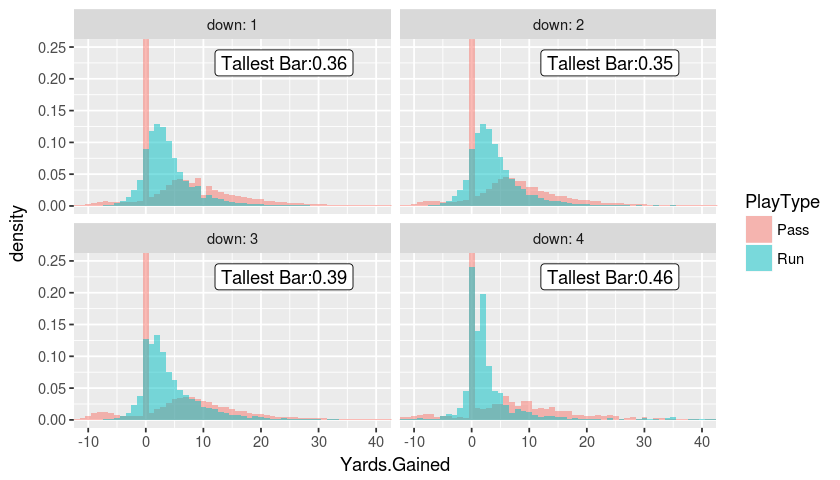

In [197]:
plot_nfl_yards(group_by_var = 'down')

Cool. The only change is that I changed the label to say "Tallest Bar", since for certain slices of the data it might not be be 0-yard Pass attempts that we're truncating (if any). Let's look at some other ways of slicing the data.

### Exploring Different Distributions of Yards.Gained

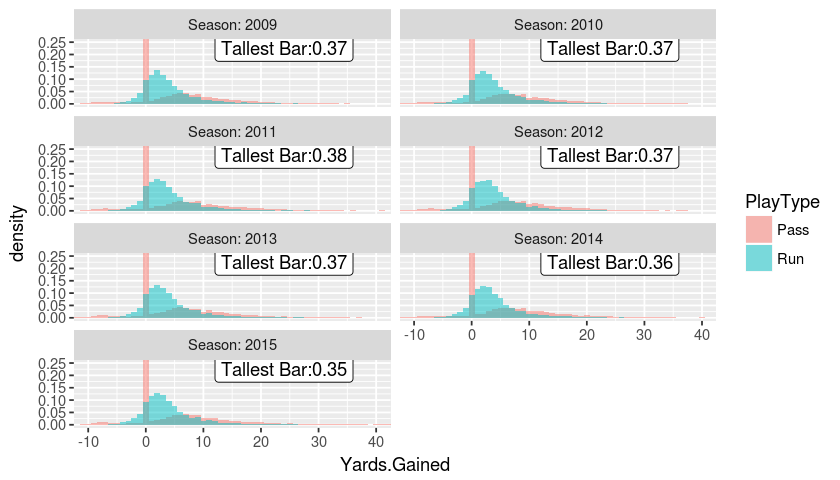

In [199]:
plot_nfl_yards(group_by_var = 'Season')

Hm, that's not so interesting. Everything looks pretty consistent by year. To the extent there may be interesting changes in yards-per-play outcomes year-to-year, this probably isn't the best plot to highlight them.

How about looking at goal-to-go situations (no chance of gaining a first down short of the end-zone)?

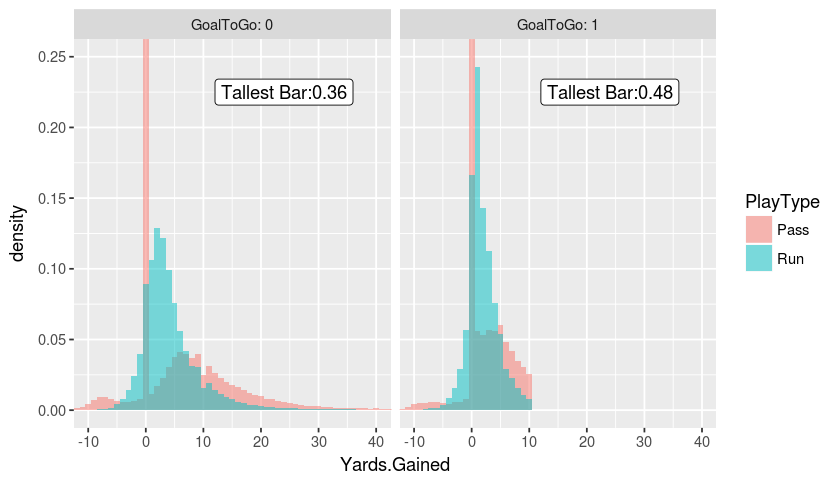

In [201]:
plot_nfl_yards(group_by_var = "GoalToGo")

Interesting. So 0-yard pass attempts go from .36 to .48 when we enter GoalToGo situations. Since 0-yard pass attempts are mainly incomplete passes, we can interpret this as "pass completion percentage is about 64% when not in Goal-to-Go situations, and down to about 52% in Goal-to-Go situations." 

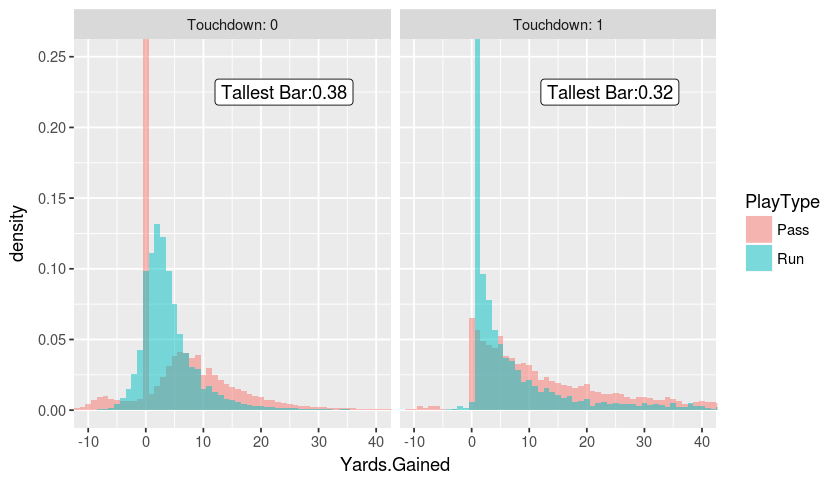

In [204]:
plot_nfl_yards(group_by_var = 'Touchdown')

Another interesting plot. First thing that stands out to me: Touchdown plays with negative Yards.Gained? 

In [217]:
td_but_neg_yards <- subset(pbp_data_2, Touchdown==1 & Yards.Gained < 0, select = c('desc', 'Touchdown', 'yrdline100', 'Yards.Gained', 'PlayType'))

head(td_but_neg_yards, 3)

desc                                                                                                                                                                                                                                    
492  (1:43) M.Bell left tackle to DET 32 for -2 yards (L.Cohen). FUMBLES (L.Cohen), touched at DET 32, RECOVERED by DET-L.Delmas at DET 35. L.Delmas for 65 yards, TOUCHDOWN. DET-E.King was injured during the play. His return is Probable.
1226 (15:00) (Shotgun) J.Delhomme sacked at CAR 15 for -10 yards (T.Cole). FUMBLES (T.Cole), RECOVERED by PHI-V.Abiamiri at CAR 2. V.Abiamiri for 2 yards, TOUCHDOWN.                                                                        
2128 (2:29) J.Campbell sacked at WAS 37 for -11 yards (O.Umenyiora). FUMBLES (O.Umenyiora), RECOVERED by NYG-O.Umenyiora at WAS 37. O.Umenyiora for 37 yards, TOUCHDOWN.                                                                     
     Touchdown yrdline100 Yards.Gained PlayType
492  1         30          -2          Run     
1226 1         75         -10          Pass    
2128 1         52         -11          Pass

Defensive Touchdowns - makes sense. And Jason Campbell makes an appearance! Sorry, JC.

The second thing that stands out is that for the first time, [0-yard pass] is not our tallest bar. Among TD-scoring plays, '1-yard Run' is our tallest bar. 

This might seem to suggest that 1-yard Runs are the most common TD-scoring plays, but that would be a misinterpretion of this plot. Each color-group in each subplot sums to 1, so that .32 in the right panel means that *of Run Plays that score a TD,* 32% are 1-yard run plays. If we want to look at the probability of scoring a TD by running vs passing when close to the end zone, we want something more like this...

## 3rd Down & Goal-To-Go... TD Success Rate for Run vs Pass

Third-down and Goal-to-Go...a Touchdown earns 7 points, and anything else is likely just 3 points. How do runs vs passes do, controlling for yard-line position?

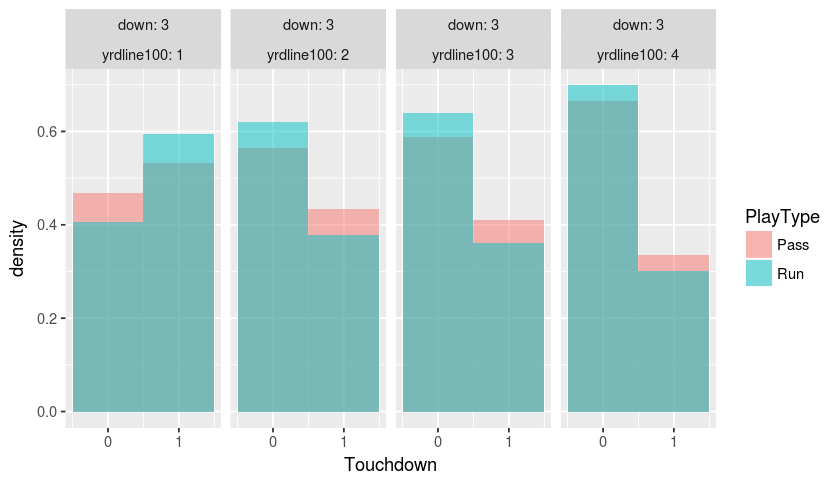

In [523]:
third_and_goal_inside4 <- subset( pbp_data_2, yrdline100 <= 4 & down == 3 & GoalToGo == 1)

ggplot(third_and_goal_inside4) + 
    geom_histogram(aes(x=Touchdown, y=..density.., fill=PlayType), binwidth=1, alpha=0.5, position="identity") +
    scale_x_continuous(breaks = c(0,1)) + #(scale continuous (0,1) is a hack because hist wont accept scale_discrete direclty or x=as.factor())
    facet_wrap(down~yrdline100, ncol=5, labeller = label_both) 



So on third-down from the 1-yardline, about 59% of run-plays gain a Touchdown while only about 53% of Pass attempts do. And on third-down from the 2-,3-, or 4-yardline, touchdown rates look even closer. 

Honestly what's most interesting here to me is how even the Run vs Pass success rates are. The divergent trend which is hinted at but kind of obscured here, which I am now interested in extrapolating further, is how the TD-rate decreases as the yards away from the end-zone increases.

## 3rd Down TD Success Rate by Yardline In Red Zone

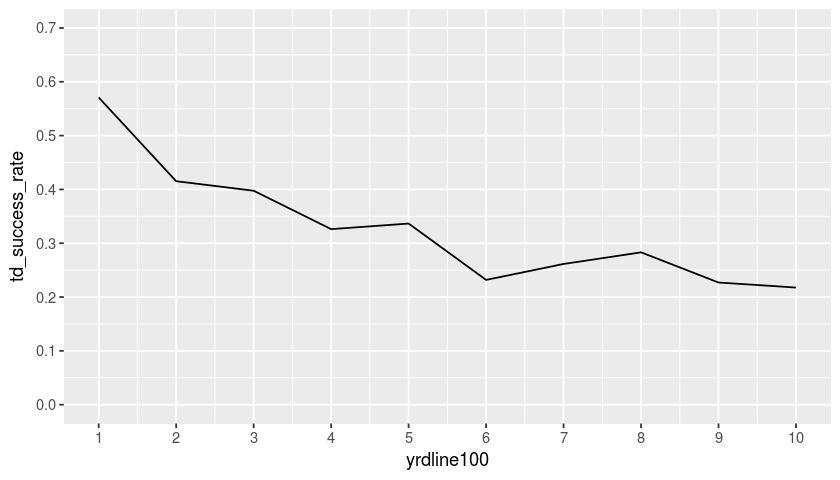

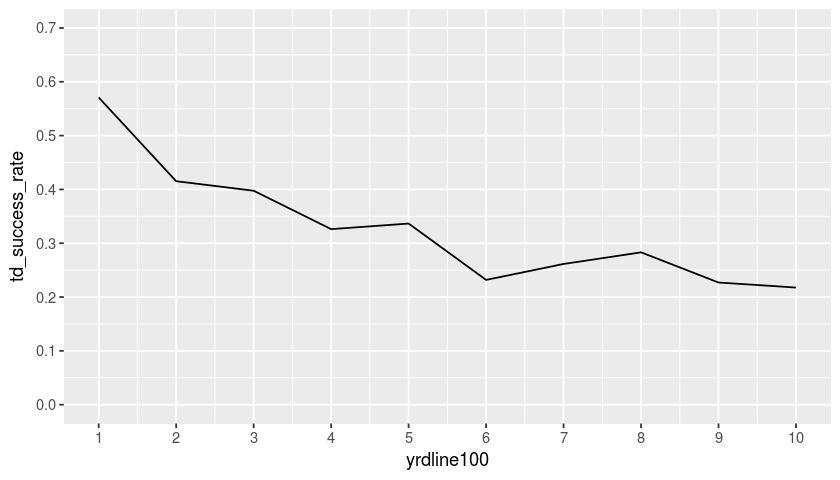

In [512]:
#'Touchdown' is always 0 or 1. Mean gives avg rate of 1, by group-by var(s)
plot_data <- pbp_data_2 %>%
                filter(yrdline100 <= 10 & down==3 & GoalToGo==1) %>%
                group_by(yrdline100) %>%
                summarise(td_success_rate = mean(Touchdown))

#Plot
ggplot(plot_data, aes(x=yrdline100, y=td_success_rate)) + 
    geom_line() +
    scale_x_continuous(breaks = seq(0,10, by=1)) +
    scale_y_continuous(breaks = seq(0,.7, by = .1), limits=c(0,.7))


We can also modify this code slightly to plot different lines by down.

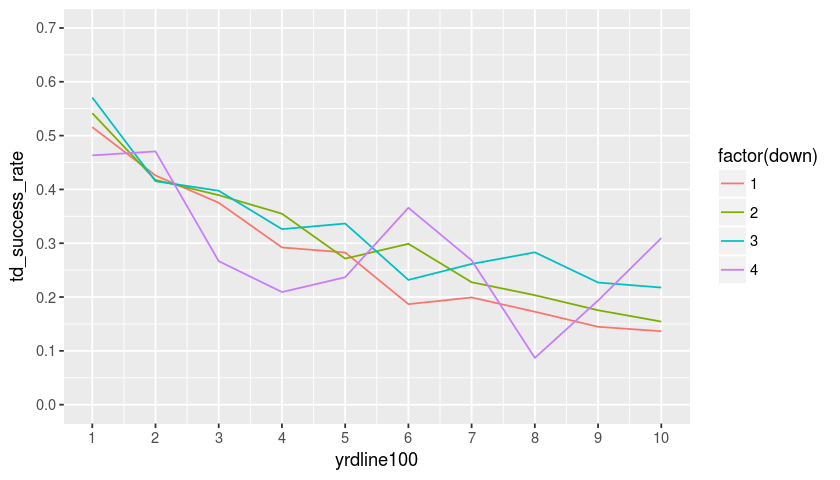

In [522]:
#Like above, except: 1) Do not filter on [down=3] and 2) Group/Summarize by (down, yrdline100), not just yrdline100
plot_data_2 <- pbp_data_2 %>%
                filter(yrdline100 <= 10 & GoalToGo==1) %>%
                group_by(down, yrdline100) %>%
                summarise(td_success_rate = mean(Touchdown))

#Plot
ggplot(plot_data_2, aes(x=yrdline100, y=td_success_rate, colour=factor(down))) + 
    geom_line() +
    scale_x_continuous(breaks = seq(0,10, by=1)) +
    scale_y_continuous(breaks = seq(0,.7, by = .1), limits=c(0,.7))
